# Model Playground

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
hssayeni_dir = Path('/projects01/didsr-aiml/brandon.nelson/pedsilicoICH/datasets/Hssayeni/')
metadata = pd.read_csv(hssayeni_dir / 'Patient_demographics.csv')
names = []
ages = []
files = []
for series_id in metadata['Patient Number']:
    if np.isnan(series_id):
        continue
    names.append(int(series_id))
    ages.append(float(metadata[metadata['Patient Number'] == series_id]['Age\n(years)']))
    files = hssayeni_dir / 'ct_scans' / f'{int(series_id):03d}.nii'
patients = pd.DataFrame(dict(name=names, age=ages, file=files))
patients

/tmp/ipykernel_3139106/4041818537.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ages.append(float(metadata[metadata['Patient Number'] == series_id]['Age\n(years)']))


,name,age,file
0,49,35.000,/projects01/didsr-aiml/brandon.nelson/pedsilic...
1,50,0.583,/projects01/didsr-aiml/brandon.nelson/pedsilic...
2,51,5.000,/projects01/didsr-aiml/brandon.nelson/pedsilic...
3,52,8.000,/projects01/didsr-aiml/brandon.nelson/pedsilic...
4,53,44.000,/projects01/didsr-aiml/brandon.nelson/pedsilic...
...,...,...,...
77,126,58.000,/projects01/didsr-aiml/brandon.nelson/pedsilic...
78,127,5.000,/projects01/didsr-aiml/brandon.nelson/pedsilic...
79,128,32.000,/projects01/didsr-aiml/brandon.nelson/pedsilic...
80,129,5.000,/projects01/didsr-aiml/brandon.nelson/pedsilic...


# CAD module

In [3]:
from model_utils import download_and_unzip
from dotenv import load_dotenv
import os
load_dotenv()

model_path = Path(os.environ['MODEL_PATH'])
if not model_path.exists():
    download_and_unzip('https://zenodo.org/records/15750437/files/model_files.zip', extract_to=model_path.parents[1]) 

/scratch/brandon.nelson/demos/pediatric_ich_cadt/.demo/lib/python3.13/site-packages/monai/utils/module.py:399: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  pkg = __import__(module)  # top level module


In [4]:
models = {m.parts[-2]: m for m in sorted(list(model_path.rglob('*.pth')))}
models

{'CAD_1': PosixPath('/scratch/brandon.nelson/demos/pediatric_ich_cadt/model_files/model_files/CAD_1/resnext101_32x8d_wsl_checkpoint.pth'),
 'CAD_2': PosixPath('/scratch/brandon.nelson/demos/pediatric_ich_cadt/model_files/model_files/CAD_2/resnext101_32x8d_wsl_checkpoint.pth'),
 'CAD_3': PosixPath('/scratch/brandon.nelson/demos/pediatric_ich_cadt/model_files/model_files/CAD_3/resnext101_32x8d_wsl_checkpoint.pth')}

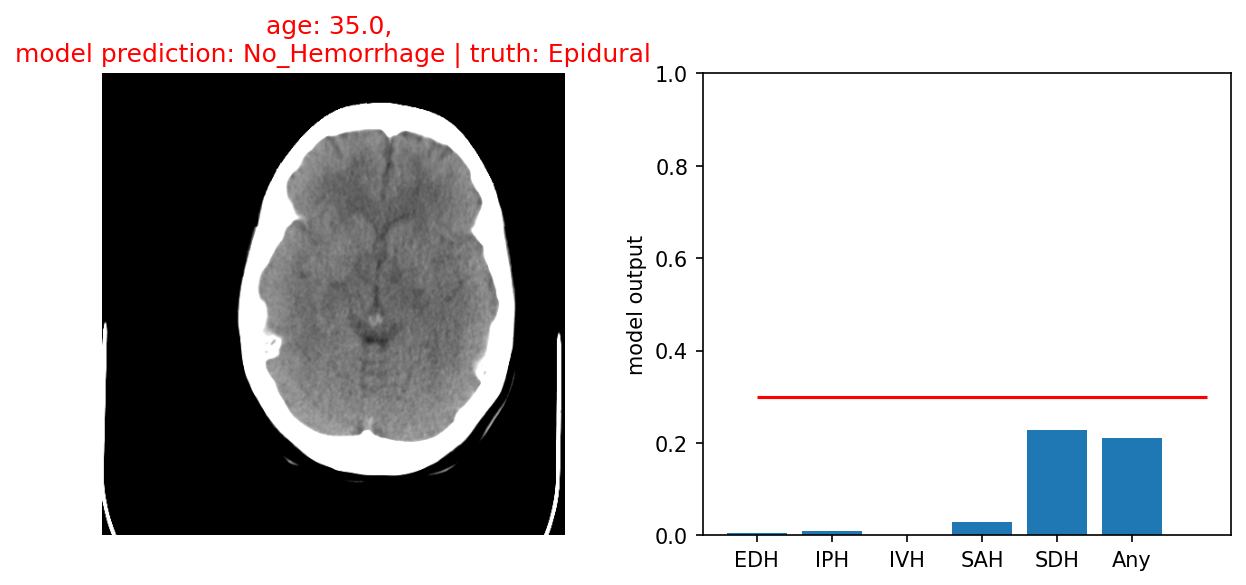

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from model_utils import predict_image

import albumentations as A
import torch
import nibabel as nib

# labels for the model output

patient = patients.iloc[0]
images = nib.load(patient['file']).get_fdata().transpose(2, 1, 0)[:, ::-1]
name = patient['name']
age = patient['age']

def ict_pipeline(slice_num, width=5, model_name='CAD_1'):

    image = np.mean(images[slice_num:slice_num+width], axis=0) # create average
    out = predict_image(image, models[model_name], device='cuda')
    return image, out



def visualize_ict_pipeline(slice_num, width=5, thresh=0.3, model_name='CAD_1', show=True):
    diagnosis = pd.read_csv(hssayeni_dir / 'hemorrhage_diagnosis_raw_ct.csv')
    label = diagnosis.loc[(diagnosis.PatientNumber == name) & (diagnosis.SliceNumber == slice_num + 1)].to_numpy()[:, 2:-1]
    cols = diagnosis.columns[2:-1]
    subtype = cols[label.argmax()]

    image, out = ict_pipeline(start)

    f, axs = plt.subplots(1, 2, figsize = (10, 4), dpi=150)
    axs[0].imshow(image, vmin=0, vmax=80, cmap='gray')
    axs[0].set_axis_off()
    axs[1].bar(out.keys(), out.values())
    axs[1].set_ylabel('model output')
    axs[1].set_ylim([0, 1])
    axs[1].hlines(thresh, 0, len(out), colors='red')
    out.pop('Any')
    max_label = [k for k, v in out.items() if v == max(out.values())][0]
    predicted_label = max_label if out[max_label] > thresh else 'No_Hemorrhage'
    color = 'green' if predicted_label == subtype else 'red'
    axs[0].set_title(f'age: {age}, \nmodel prediction: {predicted_label} | truth: {subtype}', color=color)
    fname = Path('results.png').absolute()
    if show:
        plt.show()
        return None
    else:
        plt.savefig(fname)
        return fname

start = 13
thresh = 0.3
visualize_ict_pipeline(start, width=5, thresh=0.3, model_name='CAD_1')

In [17]:
1+1

2

In [6]:
from ipywidgets import interact, IntSlider, FloatSlider
interact(visualize_ict_pipeline,
         slice_num=IntSlider(len(images)//2, 0, len(images)),
         width=IntSlider(5, 1, 10),
         thresh=FloatSlider(0.3, min=0, max=1, step=0.1),
         model_name = list(models.keys()))

interactive(children=(IntSlider(value=18, description='slice_num', max=36), IntSlider(value=5, description='wi…

<function __main__.visualize_ict_pipeline(slice_num, width=5, thresh=0.3, model_name='CAD_1', show=True)>

In [7]:
# %pip install gradio

In [8]:
%load_ext gradio

In [15]:
!export GRADIO_SERVER_PORT=7864
!export GRADIO_SERVER_NAME="0.0.0.0"

In [16]:
%%blocks

import gradio as gr
# Create the Gradio interface
iface = gr.Interface(
    fn=visualize_ict_pipeline,
    inputs=[
        gr.Slider(minimum=0, maximum=len(images), step=1, label="Slice Number"),
        gr.Slider(minimum=1, maximum=10, step=1, label="Width"),
        gr.Slider(minimum=0, maximum=1, step=0.1, label="Threshold"),
        gr.Dropdown(choices=list(models.keys()), label="Model Name")
    ],
    outputs=["image"]
)

# Launch the interface
iface.launch()

* Running on local URL:  http://127.0.0.1:7865


Exception: Couldn't start the app because 'http://127.0.0.1:7865/gradio_api/startup-events' failed (code 503). Check your network or proxy settings to ensure localhost is accessible.